In [1]:
import argparse
import os
import time
import pytorch_lightning as pl
import torchvision.transforms
from rich import print
from torch.utils.data import DataLoader
import lima
import glob
import h5py
import skimage.io as io
import torch
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import numpy as np
import cmcrameri.cm as cmc
from pykitPIV import Particle, FlowField, Motion, Image

<a id=synthetic-images></a>

***

## Generate synthetic images with `pykitPIV`

[Go to the top](#top-page)

In [2]:
image_size = (256,256)
size_buffer = 10
figsize = (5,3)

In [3]:
def generate_images(n_images, random_seed):

    tic = time.perf_counter()

    # Instantiate an object of the Particle class:
    particles = Particle(n_images,
                         size=image_size,
                         size_buffer=size_buffer,
                         diameters=(4,4.1),
                         distances=(1,2),
                         densities=(0.05,0.1),
                         signal_to_noise=(5,20),
                         diameter_std=0.2,
                         seeding_mode='random',
                         random_seed=random_seed)

    # Instantiate an object of the FlowField class:
    flowfield = FlowField(n_images,
                          size=image_size,
                          size_buffer=size_buffer,
                          random_seed=random_seed)

    flowfield.generate_random_velocity_field(gaussian_filters=(10,11),
                                             n_gaussian_filter_iter=20,
                                             displacement=(0,10))

    # Instantiate an object of the Motion class:
    motion = Motion(particles, 
                    flowfield, 
                    time_separation=0.1)

    # Advect particles:
    motion.forward_euler(n_steps=10)

    # Instantiate an object of the Image class:
    image = Image(random_seed=random_seed)

    # Prepare images - - - - - - - - - - - - - - - - - - 

    image.add_particles(particles)

    image.add_flowfield(flowfield)
  
    image.add_motion(motion)
    
    image.add_reflected_light(exposures=(0.7,0.8),
                              maximum_intensity=2**16-1,
                              laser_beam_thickness=1,
                              laser_over_exposure=1,
                              laser_beam_shape=0.95,
                              alpha=1/10)

    image.remove_buffers()

    toc = time.perf_counter()

    print(f'Time it took: {(toc - tic)/60:0.1f} minutes.\n')

    return image

<a id=synthetic-images-training-set></a>

### Training set

[Go to the top](#top-page)

In [4]:
n_images = 10

In [5]:
training_random_seed = 100

In [6]:
image_train = generate_images(n_images, training_random_seed)

image_pairs_train = image_train.image_pairs_to_tensor()
targets_train = image_train.targets_to_tensor()

Particles added to the image.
Velocity field added to the image.
Particle movement added to the image.
Reflected light added to images I1.
Reflected light added to images I2.
Buffers removed from images I1.
Buffers removed from images I2.
Buffers removed from the velocity field.


Time it took: 0.1 minutes.

In [7]:
# image_train.save_to_h5({'I': image_pairs_train, 'targets': targets_train}, filename='PIV-dataset-train.h5')

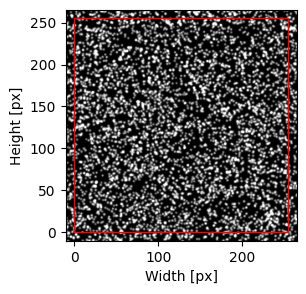

In [8]:
image_train.plot(0,
                 instance=1,
                 with_buffer=True,
                 xlabel='Width [px]',
                 ylabel='Height [px]',
                 cmap='Greys_r',
                 figsize=figsize);

In [9]:
max_of_images = np.max(image_pairs_train)
max_of_images

65535.0

<a id=synthetic-images-testing-set></a>

### Testing set

[Go to the top](#top-page)

In [10]:
n_images = 5

In [11]:
test_random_seed = 200

In [12]:
image_test = generate_images(n_images, test_random_seed)

image_pairs_test = image_test.image_pairs_to_tensor()
targets_test = image_test.targets_to_tensor()

Particles added to the image.
Velocity field added to the image.
Particle movement added to the image.
Reflected light added to images I1.
Reflected light added to images I2.
Buffers removed from images I1.
Buffers removed from images I2.
Buffers removed from the velocity field.


Time it took: 0.1 minutes.

In [13]:
# image_train.save_to_h5({'I': image_pairs_test, 'targets': targets_test}, filename='PIV-dataset-test.h5')

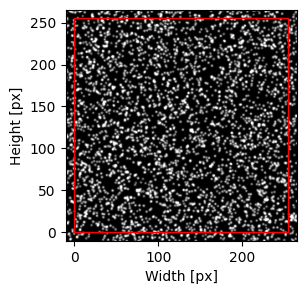

In [14]:
image_test.plot(0,
                instance=1,
                with_buffer=True,
                xlabel='Width [px]',
                ylabel='Height [px]',
                cmap='Greys_r',
                figsize=figsize);

<a id=train-LIMA></a>
***

## Train `LIMA` with the generated images

[Go to the top](#top-page)

<a id=train-LIMA-input-data></a>
### Prepare input dataset for LIMA

[Go to the top](#top-page)

In [15]:
transform = torchvision.transforms.Compose([lima.datatransform.RandomAffine(degrees=17, translate=(0.2, 0.2), scale=(0.9, 2.0)),
                                            lima.datatransform.RandomHorizontalFlip(),
                                            lima.datatransform.RandomVerticalFlip(),
                                            lima.datatransform.ToTensor(),
                                            lima.datatransform.RandomBrightness(factor=(0.5, 2)),
                                            lima.datatransform.RandomNoise(std=(0, 0)),])

In [ ]:
transform = torchvision.transforms.Compose([lima.datatransform.ToTensor()])

#### Use dataset generated on-the-fly with `pykitPIV`:

[Go to the top](#top-page)

In [16]:
class pykitPIVDataset(Dataset):
    """Load pykitPIV-generated dataset"""

    def __init__(self, image_pairs, targets, transform=None, n_samples=None, pin_to_ram=False):

        self.data = image_pairs.astype(np.float32)
        self.target = targets.astype(np.float32)

        if n_samples:
            self.data = self.data[:n_samples]
            self.target = self.target[:n_samples]
        if pin_to_ram:
            self.data = np.array(self.data)
            self.target = np.array(self.target)

        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        sample = self.data[idx], self.target[idx]
        if self.transform:
            sample = self.transform(sample)

        return sample

In [17]:
train_dataset = pykitPIVDataset(image_pairs=image_pairs_train/max_of_images,
                                targets=targets_train,
                                transform=transform)

In [18]:
test_dataset = pykitPIVDataset(image_pairs=image_pairs_test/max_of_images,
                                targets=targets_test,
                                transform=transform)

#### Use a pre-saved dataset generated with `pykitPIV`:

[Go to the top](#top-page)

In [19]:
# class pykitPIVDatasetFromPath(Dataset):
#     """Load pykitPIV-generated dataset"""

#     def __init__(self, path, transform=None, n_samples=None, pin_to_ram=False):
        
#         f = h5py.File(path, "r")
#         self.data = np.array(f["I"]).astype(np.float32)
#         self.target = np.array(f["targets"]).astype(np.float32)

#         print(self.target.max())

#         if n_samples:
#             self.data = self.data[:n_samples]
#             self.target = self.target[:n_samples]
            
#         if pin_to_ram:
#             self.data = np.array(self.data)
#             self.target = np.array(self.target)
#             f.close()
            
#         self.transform = transform

#     def __len__(self):
#         return len(self.data)

#     def __getitem__(self, idx):
        
#         if torch.is_tensor(idx):
#             idx = idx.tolist()
            
#         sample = self.data[idx], self.target[idx]
        
#         if self.transform:
#             sample = self.transform(sample)

#         return sample

In [20]:
# train_dataset = pykitPIVDatasetFromPath(path='PIV-dataset-train.h5',
#                                         transform=transform)

In [21]:
# test_dataset = pykitPIVDatasetFromPath(path='PIV-dataset-test.h5',
#                                        transform=transform)

#### Use dataset generated with Matlab:

[Go to the top](#top-page)

In [22]:
# path = 'PIV_n3_s180_maxd10_rnd_v1.h5'

In [23]:
# f = h5py.File(path, "r")

# images = f["I"]
# images = np.array(images)
# targets = f["target"]
# targets = np.array(targets)[:,2:4,:,:]

# f.close()

In [24]:
# plt.imshow(np.array(images)[0,0,:,:], cmap='Greys_r')

In [25]:
# class HDF5Dataset(Dataset):
#     """HDF5Dataset loaded"""

#     def __init__(self, path, transform=None, n_samples=None, pin_to_ram=False):
#         f = h5py.File(path, "r")
#         self.data = f["I"]
#         self.target = np.array(f["target"])[:,2:4,:,:]

#         if n_samples:
#             self.data = self.data[:n_samples]
#             self.target = self.target[:n_samples]
#         if pin_to_ram:
#             self.data = np.array(self.data)
#             self.target = np.array(self.target)
#             f.close()
#         self.transform = transform

#     def __len__(self):
#         return len(self.data)

#     def __getitem__(self, idx):
#         if torch.is_tensor(idx):
#             idx = idx.tolist()
#         sample = self.data[idx], self.target[idx]
#         if self.transform:
#             sample = self.transform(sample)

#         return sample

In [26]:
# train_dataset = HDF5Dataset(path=path,
#                             transform=transform,)

In [27]:
# test_dataset = HDF5Dataset(path=path,
#                            transform=transform,)

<a id=train-LIMA-train></a>
### Begin training

[Go to the top](#top-page)

In [31]:
train_loader = DataLoader(train_dataset,
                          batch_size=5,
                          shuffle=True,
                          num_workers=1,
                          pin_memory=True)

test_loader = DataLoader(test_dataset,
                         batch_size=10)

In [32]:
random_seed = 100

In [33]:
pl.seed_everything(random_seed, workers=True)

Global seed set to 100


100

In [34]:
model = lima.LIMA(output_level=4,
                  div_flow=0.05,
                  loss_weights=[0.005,0.01,0.02,0.04,0.08,0.04,0.04],
                  search_range=4,
                  num_chs=[1, 16, 32, 64, 96, 128, 196],
                  loss='l1_loss',
                  loss_weights_order='inc',
                  loss_J='abs',
                  loss_J_gamma=1e-1,
                  full_res=False,
                  full_res_loss_weight_multiplier=2.0,
                  epochs=20,
                  optimizer='Adam',
                  base_lr=0.001,
                  weight_decay=4e-4,
                  momentum=0.9,
                  num_workers=20,
                  beta=0.999,
                  reduction="sum",
                  scheduler='ReduceLROnPlateau',
                  lr_decay=0.2,
                  patience=5,
                  debug=2)

Estimator Context chin 83
"L4_loops":                        1
"base_lr":                         0.001
"beta":                            0.999
"corr":                            cost
"debug":                           2
"debug_path":                      log
"div_flow":                        0.05
"epochs":                          20
"full_res":                        False
"full_res_loss_weight_multiplier": 2.0
"ipol_mode":                       bilinear
"loss":                            l1_loss
"loss_J":                          abs
"loss_J_gamma":                    0.1
"loss_factor":                     8.0
"loss_norm":                       True
"loss_reduction":                  mean
"loss_weights":                    [0.005, 0.01, 0.02, 0.04, 0.08, 0.04, 0.04]
"loss_weights_order":              inc
"lr_decay":                        0.2
"momentum":                        0.9
"num_chs":                         [1, 16, 32, 64, 96, 128, 196]
"num_workers":                     2

In [37]:
image_pairs_train.shape

(10, 2, 256, 256)

In [38]:
x_init = torch.from_numpy(image_pairs_train[0,0,:,:])

In [39]:
init_features = model.feature_pyramid_extractor.forward(x_init)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/zdka/miniconda3/envs/lima_lento/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3550, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_25771/873109598.py", line 1, in <module>
    init_features = model.feature_pyramid_extractor.forward(x_init)
  File "/home/zdka/GitLab-Empa/lima/src/lima/lima.py", line 228, in forward
  File "/home/zdka/miniconda3/envs/lima_lento/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1102, in _call_impl
    return forward_call(*input, **kwargs)
  File "/home/zdka/miniconda3/envs/lima_lento/lib/python3.9/site-packages/torch/nn/modules/container.py", line 141, in forward
    input = module(input)
  File "/home/zdka/miniconda3/envs/lima_lento/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1102, in _call_impl
    return forward_call(*input, **kwargs)
  File "/home/zdka/miniconda3/envs/lima_lento/lib/python3.9/site-packages/torc

In [ ]:
trainer = pl.Trainer(gpus=1)

In [ ]:
trainer.fit(model,
            train_loader,
            test_loader)

In [ ]:
# prediction = trainer.predict(model, test_loader)

<a id=predict></a>
***

## Make predictions from the trained network

[Go to the top](#top-page)

In [ ]:
image_to_predict = 1
velocity_component = 0

In [ ]:
# x = torch.rand(1, 2, 100, 100).cpu()
# predicted_flow = model.inference(x)

In [ ]:
predicted_flow = model.inference(image_pairs_test[image_to_predict,:,:,:].astype(np.float32)/max_of_images)

In [ ]:
for i in range(0,7):
    print(predicted_flow[i].shape)

In [ ]:
plt.imshow(predicted_flow[-1][velocity_component,:,:], 
           cmap=cmc.batlow, 
           origin='lower')
plt.colorbar();

In [ ]:
plt.imshow(targets_test[image_to_predict,velocity_component,:,:], 
           cmap=cmc.batlow, 
           origin='lower')
plt.colorbar();

In [ ]:
num_chs=[1, 16, 32, 64, 96, 128, 196]

In [ ]:
for l, (ch_in, ch_out) in enumerate(zip(num_chs[:-1], num_chs[1:])):
    print('(' + str(ch_in) + ', ' + str(ch_out) + ')')
    print('(' + str(ch_out) + ', ' + str(ch_out) + ')')

***